In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.core.debugger import set_trace
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

run_first = False
run_all = False
run_second = False

/kaggle/input/playground-series-s3e23/sample_submission.csv
/kaggle/input/playground-series-s3e23/train.csv
/kaggle/input/playground-series-s3e23/test.csv


In [2]:
#Set flags to choose which cells to run
run_first = False

Here is the initial plan:
1. Basic data exploration:info, descibe, NaN,
2. Data visualization
3. Clean data and impute using copies and custom functions
4. Explore MI
5. Explore model types and utilize feature importance and well as various measurements of success.
6. Choose best model and features, train, fit, submit
    
    

In [3]:
df = pd.read_csv('/kaggle/input/playground-series-s3e23/train.csv')
X_test = pd.read_csv('/kaggle/input/playground-series-s3e23/test.csv')
X=df.copy()
y = X['defects']

In [4]:
X.head()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 101763 non-null  int64  
 1   loc                101763 non-null  float64
 2   v(g)               101763 non-null  float64
 3   ev(g)              101763 non-null  float64
 4   iv(g)              101763 non-null  float64
 5   n                  101763 non-null  float64
 6   v                  101763 non-null  float64
 7   l                  101763 non-null  float64
 8   d                  101763 non-null  float64
 9   i                  101763 non-null  float64
 10  e                  101763 non-null  float64
 11  b                  101763 non-null  float64
 12  t                  101763 non-null  float64
 13  lOCode             101763 non-null  int64  
 14  lOComment          101763 non-null  int64  
 15  lOBlank            101763 non-null  int64  
 16  lo

#  Notably, there are no object type variables and no NaN values.  This makes data cleaning easy!!

In [6]:
X.describe()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
count,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,...,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000
mean,50881.000000,37.347160,5.492684,2.845022,3.498826,96.655995,538.280956,0.111634,13.681881,27.573007,...,1141.357982,22.802453,1.773945,3.979865,0.196604,11.896131,15.596671,57.628116,39.249698,9.839549
std,29376.592059,54.600401,7.900855,4.631262,5.534541,171.147191,1270.791601,0.100096,14.121306,22.856742,...,9862.795472,38.541010,5.902412,6.382358,0.998906,6.749549,18.064261,104.537660,71.692309,14.412769
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,25440.500000,13.000000,2.000000,1.000000,1.000000,25.000000,97.670000,0.050000,5.600000,15.560000,...,31.380000,7.000000,0.000000,1.000000,0.000000,8.000000,7.000000,15.000000,10.000000,3.000000
50%,50881.000000,22.000000,3.000000,1.000000,2.000000,51.000000,232.790000,0.090000,9.820000,23.360000,...,125.400000,14.000000,0.000000,2.000000,0.000000,11.000000,12.000000,30.000000,20.000000,5.000000
75%,76321.500000,42.000000,6.000000,3.000000,4.000000,111.000000,560.250000,0.150000,18.000000,34.340000,...,565.920000,26.000000,1.000000,5.000000,0.000000,16.000000,20.000000,66.000000,45.000000,11.000000
max,101762.000000,3442.000000,404.000000,165.000000,402.000000,8441.000000,80843.080000,1.000000,418.200000,569.780000,...,935923.390000,2824.000000,344.000000,219.000000,43.000000,410.000000,1026.000000,5420.000000,3021.000000,503.000000


Let's check for dublicate data

In [7]:
#Check for duplicates
X.duplicated().sum()

0

 #from https://www.kaggle.com/competitions/playground-series-s3e23/discussion/444627
 
  1. loc             : numeric % McCabe's line count of code
  2. v(g)            : numeric % McCabe "cyclomatic complexity"
  3. ev(g)           : numeric % McCabe "essential complexity"
  4. iv(g)           : numeric % McCabe "design complexity"
  5. n               : numeric % Halstead total operators + operands
  6. v               : numeric % Halstead "volume"
  7. l               : numeric % Halstead "program length"
  8. d               : numeric % Halstead "difficulty"
  9. i               : numeric % Halstead "intelligence"
 10. e               : numeric % Halstead "effort"
 11. b               : numeric % Halstead 
 12. t               : numeric % Halstead's time estimator
 13. lOCode          : numeric % Halstead's line count
 14. lOComment       : numeric % Halstead's count of lines of comments
 15. lOBlank         : numeric % Halstead's count of blank lines
 16. lOCodeAndComment: numeric
 17. uniq_Op         : numeric % unique operators
 18. uniq_Opnd       : numeric % unique operands
 19. total_Op        : numeric % total operators
 20. total_Opnd      : numeric % total operands
 21: branchCount     : numeric % of the flow graph
 22. defects         : {false,true} % module has/has not one or more  reported defects
 
 Further research:
 
 2. v(g)            : numeric % McCabe "cyclomatic complexity" - has been shown to be correlated with length of code.  Correlating v(g)  with defects on its own has had mixed results. https://en.wikipedia.org/wiki/Cyclomatic_complexity#Correlation_to_number_of_defects
 And, https://www.scirp.org/journal/paperinformation.aspx?paperid=779: "from Employing modern regression techniques, we find the linearity of this relationship has been severely underestimated, so much so that CC can be said to have absolutely no explana-tory power of its own." 


3. ev(g)           : numeric % McCabe "essential complexity" - a measurement of how structured a program is. The closer to 1, the more strucured the program is.  If code has a high ev(g) value and has a low loc (line count) then it may just be a very simple program. https://www.ibm.com/docs/en/raa/6.1?topic=metrics-essential-complexity

4. iv(g)           : numeric % McCabe "design complexity" - 
http://www.mccabe.com/iq_research_metrics.htm
Module Design Complexity Metric (iv(G))
Module Design Complexity (iv(G)) is the complexity of the design-reduced module and reflects the complexity of the module's calling patterns to its immediate subordinate modules. This metric differentiates between modules which will seriously complicate the design of any program they are part of and modules which simply contain complex computational logic. It is the basis upon which program design and integration complexities (S0 and S1) are calculated.

# There are many articles suggesting that line count alone is the best predictor of defects in code.  Lets make a baseline prediction using just 'loc'

In [8]:
if run_first:
    X['loc'].hist(bins=50);

In [9]:
if run_first:
    #Dist looks exponential.
    #Check for neg values
    X['loc'].min()

In [10]:
if run_first:
    #no neg values - try box-cox transform
    #For the first submission, just use full train data and fit test, submit.
    X_loc_train=X['loc']
    y_train = X['defects']
    X_loc_train, best_lambda = stats.boxcox(X_loc_train)
    X_loc_train = pd.DataFrame(X_loc_train, columns=['loc'])

    #Look at transformed dist
    X_loc_train['loc'].hist(bins=50);

In [11]:
if run_first:
    model= RandomForestClassifier()
    model.fit(X_loc_train,y_train)

In [12]:
if run_first:
    #fit test data
    X_loc_test=X_test['loc']

    X_loc_test, best_lambda = stats.boxcox(X_loc_test)
    X_loc_test = pd.DataFrame(X_loc_test, columns = ['loc'])
    X_loc_test.head()
    predictions1 = pd.DataFrame(model.predict(X_loc_test),columns=['defects'])
    predictions1['id'] = X_test['id']

    predictions1.head()

In [13]:
if run_first:
    #submit to compitition
    predictions1.to_csv('submission.csv', index=False)

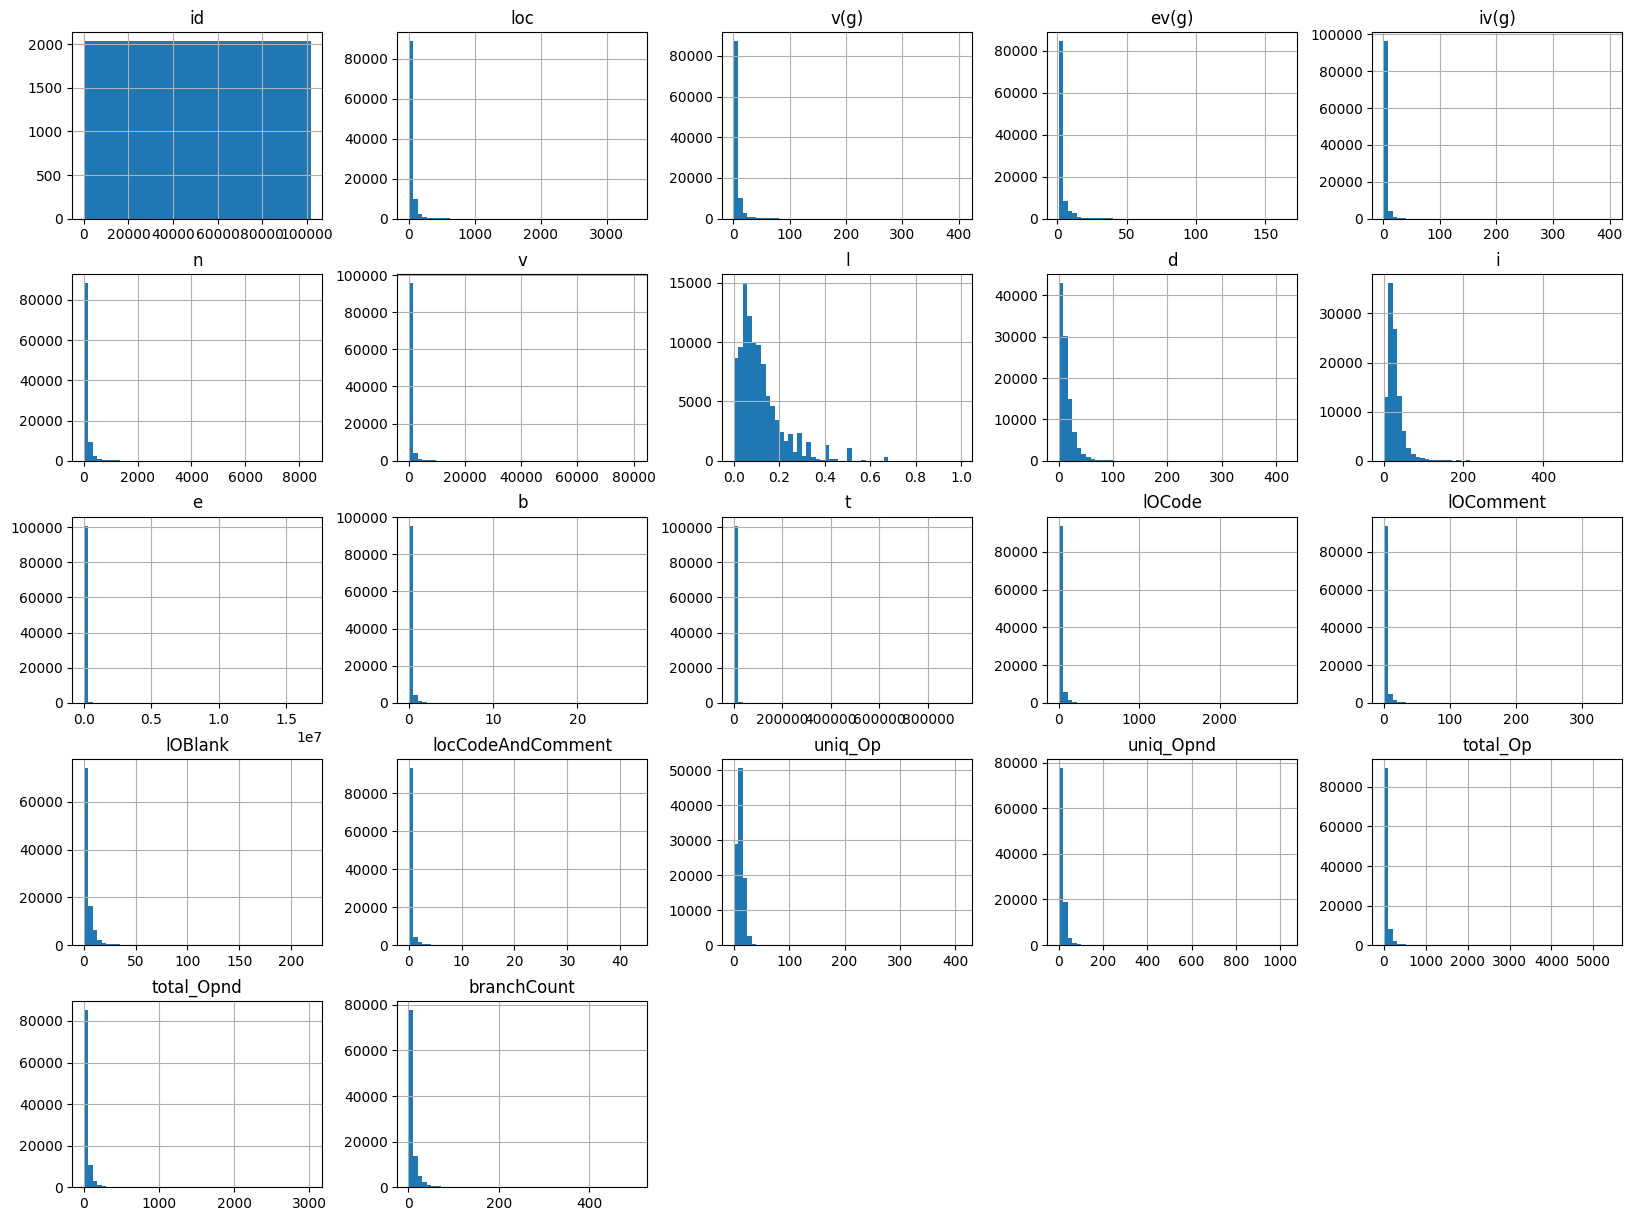

In [14]:
#Look at distribution of all data

X.hist(bins=50,figsize=(20,15));
    

# Much of this data has an exponential dist.  Lets look at some box-cox transforms.

In [15]:
#use scipy to automatically find the best lambda value
from scipy import stats 
#note: scipy transforms and returns optimal lambda, scikit learn does the same transform but without returning best lambda

X_bc = X.drop('defects',axis=1).copy()
bc_best_lambda=pd.Series()
for col in X_bc.columns:
    #check for negative values
    if X_bc[col].min()>0:
        X_bc[col], bc_best_lambda[col] = stats.boxcox(X_bc[col])
    else:
        X_bc[col], bc_best_lambda[col] = stats.boxcox(X_bc[col]+1)
        print(col,' contains a negative number.  Min value: ', X_bc[col].min(),' Adding 1 to all rows.')
bc_best_lambda

#Look at new distributions:

id  contains a negative number.  Min value:  0.0  Adding 1 to all rows.
n  contains a negative number.  Min value:  0.0  Adding 1 to all rows.
v  contains a negative number.  Min value:  0.0  Adding 1 to all rows.
l  contains a negative number.  Min value:  0.0  Adding 1 to all rows.
d  contains a negative number.  Min value:  0.0  Adding 1 to all rows.
i  contains a negative number.  Min value:  0.0  Adding 1 to all rows.
e  contains a negative number.  Min value:  0.0  Adding 1 to all rows.
b  contains a negative number.  Min value:  0.0  Adding 1 to all rows.
t  contains a negative number.  Min value:  0.0  Adding 1 to all rows.
lOCode  contains a negative number.  Min value:  0.0  Adding 1 to all rows.
lOComment  contains a negative number.  Min value:  0.0  Adding 1 to all rows.
lOBlank  contains a negative number.  Min value:  0.0  Adding 1 to all rows.
locCodeAndComment  contains a negative number.  Min value:  0.0  Adding 1 to all rows.
uniq_Op  contains a negative number.  Min

id                    0.707161
loc                  -0.166694
v(g)                 -0.210829
ev(g)                -1.553674
iv(g)                -0.378236
n                     0.190640
v                     0.197203
l                    -6.295546
d                     0.231510
i                     0.431690
e                     0.112189
b                    -5.441001
t                     0.040991
lOCode                0.116499
lOComment            -1.767003
lOBlank              -0.144242
locCodeAndComment   -11.488829
uniq_Op               0.693889
uniq_Opnd             0.243076
total_Op              0.158138
total_Opnd            0.120200
branchCount          -0.032877
dtype: float64

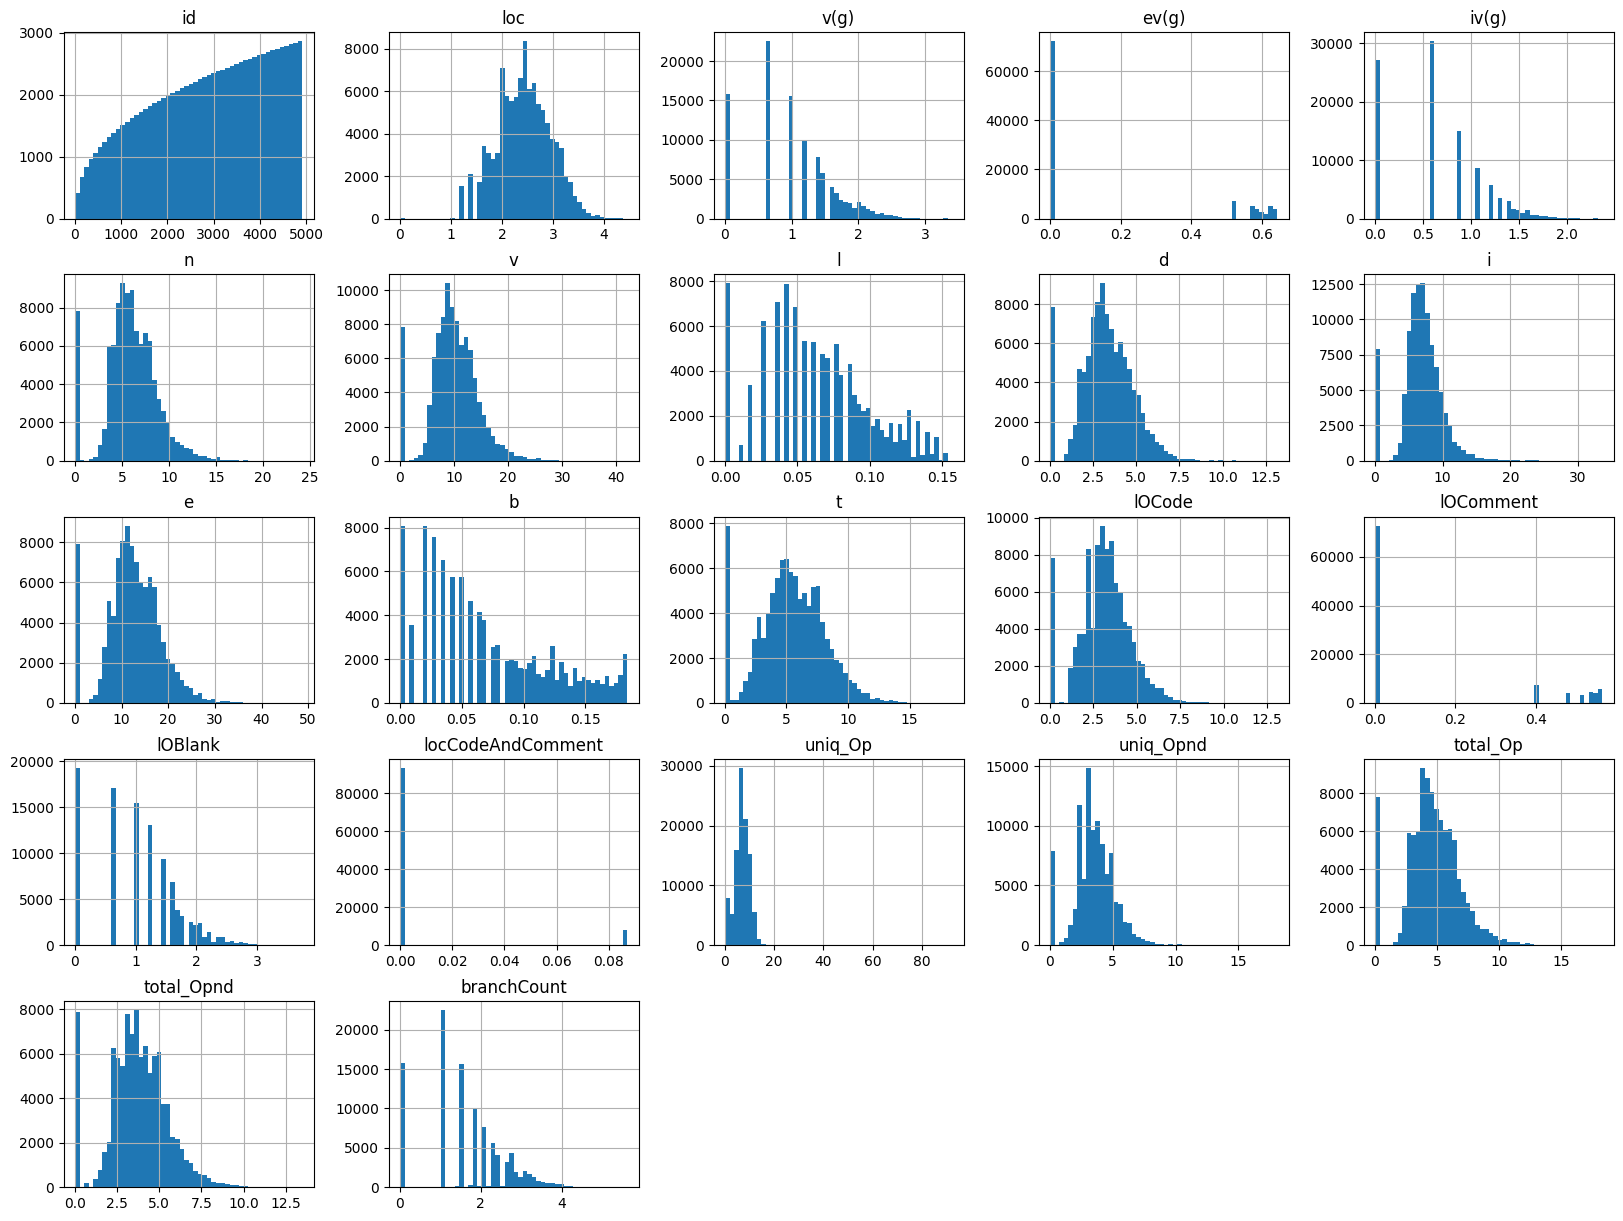

In [16]:
#lets see what the transformed distributions look like
X_bc.hist(bins=50,figsize=(20,15));

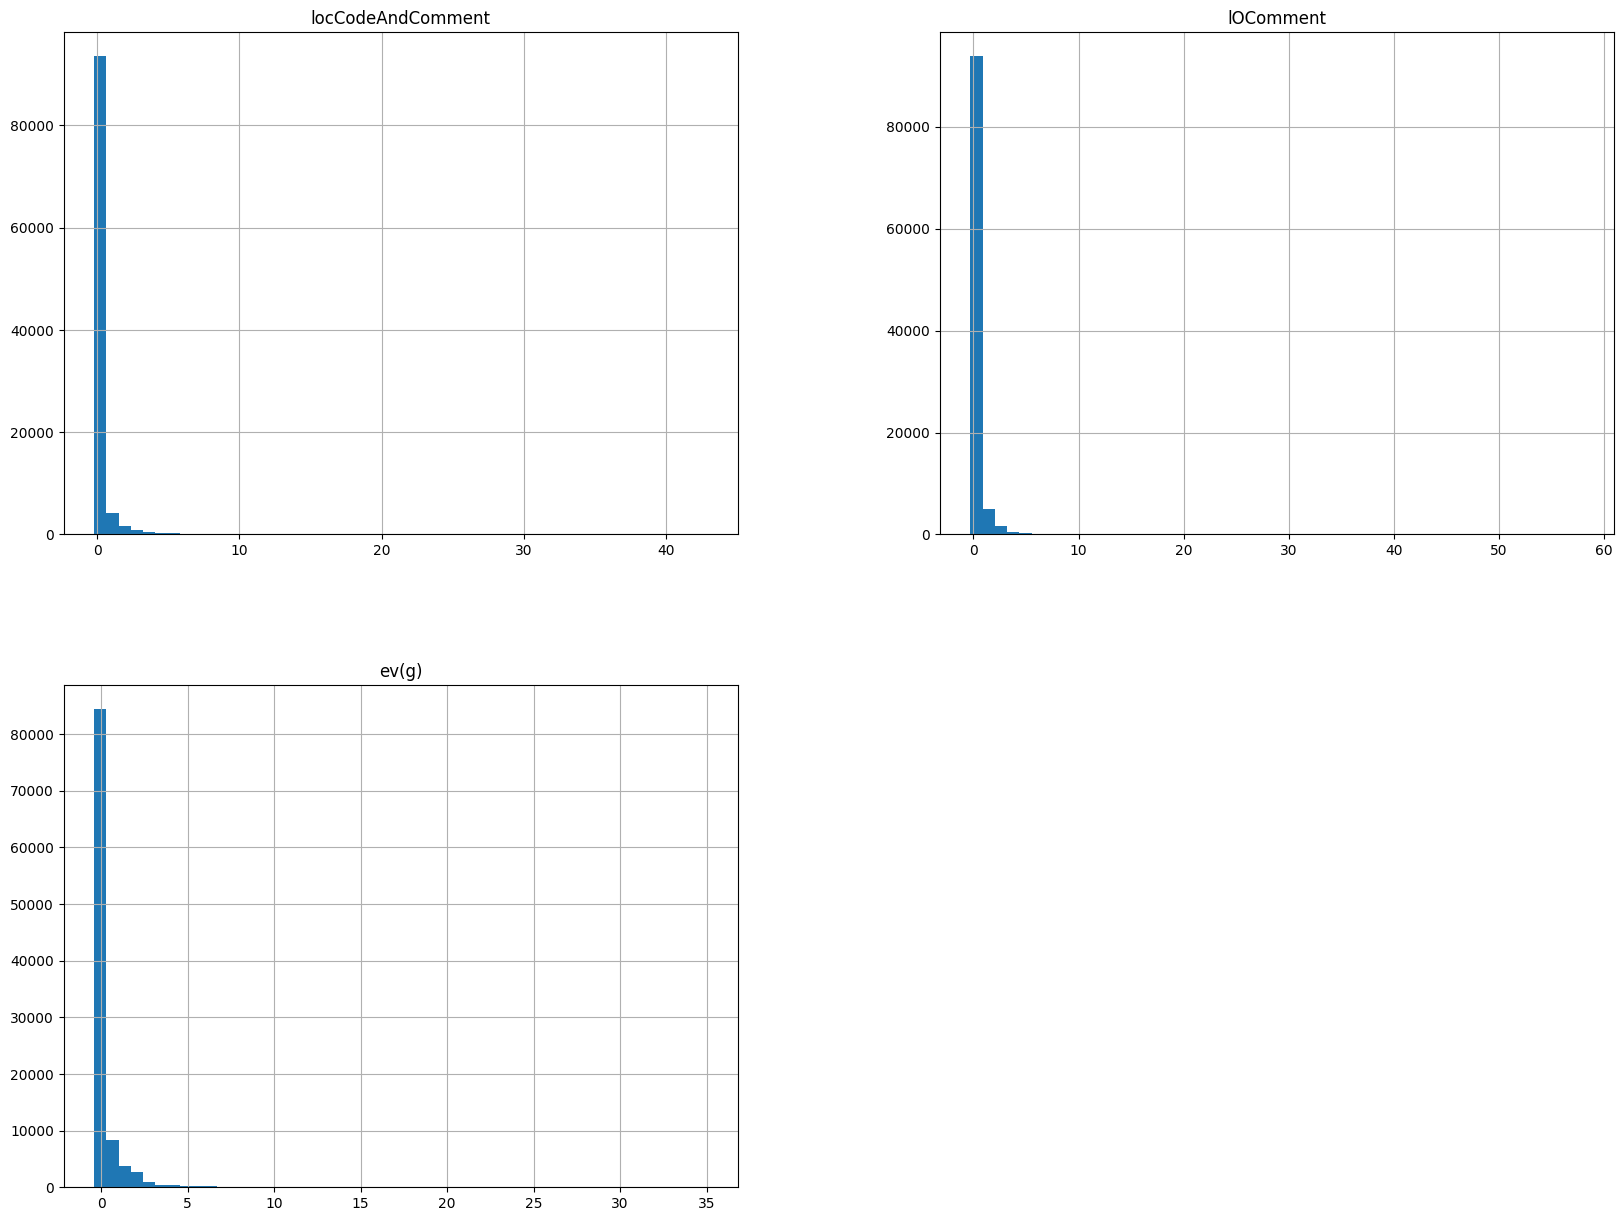

In [17]:
#Some of these don't look very gaussian... we can experiment with different transformations
features=['locCodeAndComment','lOComment','ev(g)']

X_ss = X[features]
my_ss = StandardScaler()
X_ss = pd.DataFrame(my_ss.fit_transform(X_ss),columns=features)
#for col in X_ss.columns:
#    X_ss[col] = stats.standard_scalar(X_ss[col])

    #lets see what the transformed distributions look like
X_ss.hist(bins=50,figsize=(20,15));

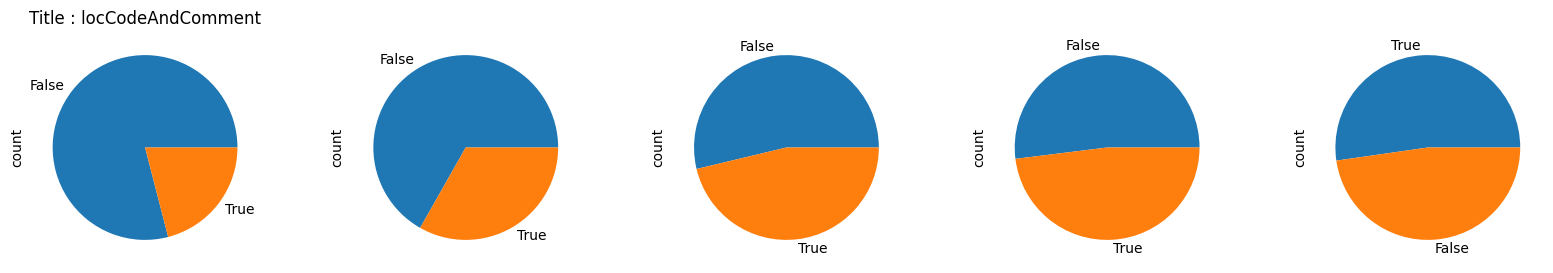

In [18]:
fig = plt.figure(figsize=(20,3))
fig.add_subplot(1,5,1)
plt.title('Title : {}'.format('locCodeAndComment'))
X_ss['defects'] = X['defects'].copy()
#X_ss.describe()
X_ss['defects'][X_ss['locCodeAndComment'].between(-.5,0)].value_counts().plot(kind='pie')
fig.add_subplot(1,5,2)
X_ss['defects'][X_ss['locCodeAndComment'].between(0,1)].value_counts().plot(kind='pie')
fig.add_subplot(1,5,3)
X_ss['defects'][X_ss['locCodeAndComment'].between(1,2)].value_counts().plot(kind='pie')
fig.add_subplot(1,5,4)
X_ss['defects'][X_ss['locCodeAndComment'].between(2,3)].value_counts().plot(kind='pie')
fig.add_subplot(1,5,5)
X_ss['defects'][X_ss['locCodeAndComment'].between(3,4)].value_counts().plot(kind='pie');

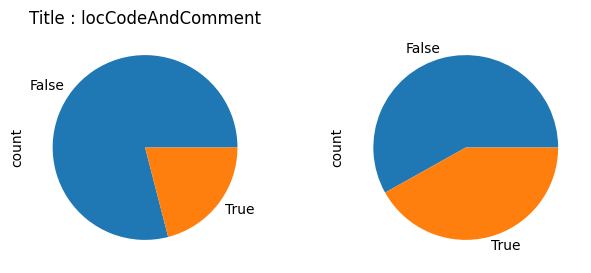

In [19]:
fig = plt.figure(figsize=(20,3))
fig.add_subplot(1,5,1)
plt.title('Title : {}'.format('locCodeAndComment'))
X_bc['defects'] = X['defects'].copy()
X_bc.describe()
X_bc['defects'][X_bc['locCodeAndComment']==0].value_counts().plot(kind='pie')
fig.add_subplot(1,5,2)
X_bc['defects'][X_bc['locCodeAndComment']>.01].value_counts().plot(kind='pie');


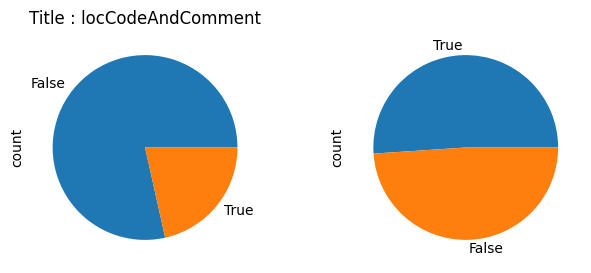

In [20]:
fig = plt.figure(figsize=(20,3))
fig.add_subplot(1,5,1)
plt.title('Title : {}'.format('locCodeAndComment'))

#X_ss.describe()
X['defects'][X['locCodeAndComment']<=1].value_counts().plot(kind='pie')
fig.add_subplot(1,5,2)
X['defects'][X['locCodeAndComment']>1].value_counts().plot(kind='pie');


<Axes: xlabel='defects'>

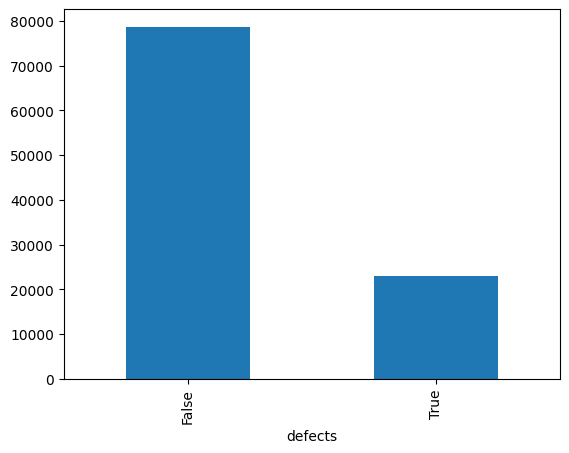

In [21]:
#Check for data imbalance...
X['defects'].value_counts().plot.bar()

True constituts about 25% of data - only mild data imbalance

In [22]:
def build_random_forest(X_train,y_train,X_valid, max_depth = 10,n = 100,return_model=True):
    model = RandomForestClassifier(random_state=0,max_depth=max_depth,n_estimators=n)
    model.fit(X_train,y_train)
    predictions = model.predict_proba(X_valid)
    if return_model:
        return predictions, model
    return predictions
    
def get_model_metrics(y_valid,predictions):
#     from sklearn.metrics import accuracy_score
#     print('Accuracy Score: ')
#     print(accuracy_score(y_valid, predictions))

#     ####classification score code from datacamp.com cheatsheet
#     from sklearn.metrics import classification_report #Precision, recall, f1-score and support
#     print('Clissification score:')
#     print(classification_report(y_valid, predictions))

#     ####confusion matrix score code from datacamp.com cheatsheet
#     from sklearn.metrics import confusion_matrix
#     print('Confusion Matrix: ')
#     print(confusion_matrix(y_valid,predictions))
    
    from sklearn.metrics import roc_auc_score
    print('ROC AUC: ')
    print(roc_auc_score(y_valid,predictions))


In [23]:
def get_random_forest_FI(model,feature_names):
    #plot and return feature importance for random forest model
    importances = model.feature_importances_
    my_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    
    fig, ax = plt.subplots()
    my_importances.plot.bar( ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    
    return my_importances

In [24]:
#mutual information - 
def get_mutual_information(X,y):
    from sklearn.feature_selection import mutual_info_classif as MIC
    mi_score = MIC(X,y,random_state=0)
    mi_score = pd.Series(mi_score,index=X.columns)
    mi_score =mi_score.sort_values(ascending=False)
    return mi_score

In [25]:
#split the data into training and validation
from sklearn.model_selection import train_test_split

X_=X.drop('defects',axis=1)
# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = train_test_split(X_, y, stratify=y, train_size=0.8, random_state=0)


In [26]:
if True:
    #Lets take a gander at the Mutual information
    mi_scores = get_mutual_information(X_train,y_train)
    mi_scores

loc                  0.100754
lOCode               0.088030
t                    0.087391
total_Op             0.086619
v                    0.086362
e                    0.085485
b                    0.084841
total_Opnd           0.084428
n                    0.083529
uniq_Opnd            0.082664
i                    0.077302
d                    0.076531
uniq_Op              0.072870
v(g)                 0.072463
branchCount          0.069515
l                    0.068555
iv(g)                0.067832
lOBlank              0.058133
ev(g)                0.037633
lOComment            0.027122
locCodeAndComment    0.010218
id                   0.002492
dtype: float64

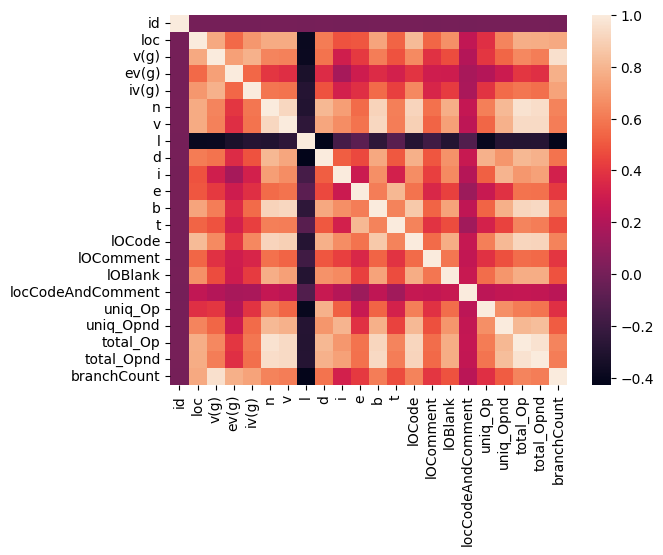

In [27]:
import seaborn as sns
sns.heatmap(X_train.corr())
plt.show();


# Let's try out a random forest model with different types of normalization

In [28]:
#first try no normalization
#if run_all:
if False:
    predictions, model = build_random_forest(X_train,y_train,X_valid)
    get_model_metrics(y_valid,predictions[:,1])


In [29]:
#Try some feature selection to remove heavily correlated features
X_train_uncorr = X_train.drop(['v','n','total_Opnd','b','total_Op','branchCount'],axis=1)

X_valid_uncorr = X_valid.drop(['v','n','total_Opnd','b','total_Op','branchCount'],axis=1)


In [30]:
#run RandomForest on uncorr
if False:
    predictions, model = build_random_forest(X_train_uncorr,y_train,X_valid_uncorr,n=100)
    get_model_metrics(y_valid,predictions[:,1])


In [31]:
#Check out feature importance
if run_all:
#if True:
    feature_names = X_train.columns
    fi = get_random_forest_FI(model,feature_names)
    fi

In [32]:
#Try StandardScalar
if run_all:
    my_ss = StandardScaler()
    X_train_ss = pd.DataFrame(my_ss.fit_transform(X_train),columns=X_train.columns)
    X_valid_ss = pd.DataFrame(my_ss.transform(X_valid),columns=X_valid.columns)

    predictions = build_random_forest(X_train_ss,y_train,X_valid_ss)
    get_model_metrics(y_valid,predictions)

In [33]:
# #Try boxcox***** Try this later*******

# bc = PowerTransformer(method = 'box-cox')

# X_train_bc = X_train.copy()
# X_valid_bc = X_valid.copy()
# for col in X_train_bc.columns:
#     #check for negative values and add 1 where needed
#     if (X_train_bc[col].min()<=0) | (X_valid_bc[col].min()<=0):
#         X_train_bc[col] = X_train_bc[col] + 1
#         X_valid_bc[col] = X_valid_bc[col] + 1
#         print(col,' contains a negative number.  Min value: ', X_train_bc[col].min(),' Adding 1 to all rows.')
#     X_train_bc = bc.fit_transform(X_train_bc)
#     X_valid_bc = bc.transform(X_valid_bc)

        
# predictions = build_random_forest(X_train_bc,y_train,X_valid_bc)
# get_model_metrics(y_valid,predictions)

In [34]:
#try yao-johnson
if run_all:
    yj = PowerTransformer(method = 'yeo-johnson')

    X_train_yj = pd.DataFrame(yj.fit_transform(X_train),columns=X_train.columns)
    X_valid_yj = pd.DataFrame(yj.transform(X_valid),columns=X_valid.columns)

    predictions = build_random_forest(X_train_yj,y_train,X_valid_yj)
    get_model_metrics(y_valid,predictions)

# Normalizing the data has no affect on the random forest model

In [35]:
#drop id column
X_train.drop('id',axis=1,inplace=True)
X_valid.drop('id',axis=1,inplace=True)
test_ids = X_test['id']
X_test.drop('id',axis=1,inplace=True)

In [36]:
#X_test.info()

In [37]:
run_second = True
if run_second:
    #recombine test and validation, train model and predict test
    X_full = pd.concat([X_train,X_valid],axis=0)
    y_full = pd.concat([y_train,y_valid],axis=0)
    #drop heaviy correlated columns
    X_full.drop(['v','n','total_Opnd','b','total_Op','branchCount'],axis=1,inplace=True)
    X_test.drop(['v','n','total_Opnd','b','total_Op','branchCount'],axis=1,inplace=True)
    predictions = build_random_forest(X_full,y_full,X_test,return_model=False)
    
    prediction_df = pd.DataFrame(predictions[:,1],columns = ['defects'])
    prediction_df['id'] = test_ids
    prediction_df.head()
    prediction_df.to_csv('submission.csv', index=False)


,defects,id
0,0.246653,101763
1,0.191681,101764
2,0.675190,101765
3,0.451813,101766
4,0.135252,101767


In [38]:
#use model.predict_proba to return probabilities, then use ROC AUC to give a score at different thresholds for validation.